In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from copy import deepcopy
from IPython.display import Latex

In [2]:
# lag settimanali da utilizzare
lags = [1, 2, 3]

In [3]:
# directory base dei file
base_dir = "/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2"

# nomi variabili e dataset di riferimento
fnames = {
    "sorveglianza_entomologica": "sorveglianza_entomologica.csv",
    "sorveglianza_equidi": "sorveglianza_equidi.csv",
    "sorveglianza_uccelli_bersaglio": "sorveglianza_uccelli_bersaglio.csv",
    "sorveglianza_uccelli_selvatici": "sorveglianza_uccelli_selvatici.csv",
    "sorveglianza_umana": "casi_per_regione.csv",
}

# colonne da escludere
excl_cols = [
    "url_bollettino",
    "casi_totali",
    "totalSnow_cm",
    "sunHour",
    "moon_illumination",
    "moonrise", "moonset",
    "sunrise", "sunset",
    "DewPointC", "FeelsLikeC", "HeatIndexC",
    "WindGustKmph", "visibility",
    "winddirDegree",
    "nuovi_morti_abbattuti", "totale_morti_abbattuti",
    "equidi_presenti_focolaio",
    "nuovi_decessi", "decessi_totali", "specie"
]

# errori di date (non più necessario)
_ = """
dt_errors = [
    [pd.to_datetime("2019-11-25"), pd.to_datetime("2019-11-24")],
    [pd.to_datetime("2020-08-13"), pd.to_datetime("2020-08-12")],
    [pd.to_datetime("2020-08-20"), pd.to_datetime("2020-08-19")],
    [pd.to_datetime("2020-08-27"), pd.to_datetime("2020-08-26")],
]
"""

In [4]:
# verifica nomi regioni
region_names = set()

# per ogni anno
for year in np.arange(2012, 2023)[::-1]:
    # dataset meteo
    wname = f"{base_dir}/{year}/dati/weather/regioni/weather_{year}.csv"
    _w = pd.read_csv(wname)
    # aggiunta dei nomi regioni
    region_names = region_names.union(set(_w.location.str.lower().unique()))
    # datasets West-Nile
    for i, f in enumerate(fnames):
        try:
            fname = f"{base_dir}/{year}/dati/{f}/{fnames[f].format(year=year)}"
            _df = pd.read_csv(fname)
            # aggiunta nomi regioni
            region_names = region_names.union(set(_df.regione.str.lower().unique()))
        except Exception as e:
            # errore dove non trovato
            print("******************************************")
            print(year, f, e)

******************************************
2016 sorveglianza_entomologica [Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_entomologica/sorveglianza_entomologica.csv'
******************************************
2016 sorveglianza_equidi [Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_equidi/sorveglianza_equidi.csv'
******************************************
2016 sorveglianza_uccelli_bersaglio [Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_uccelli_bersaglio/sorveglianza_uccelli_bersaglio.csv'
******************************************
2016 sorveglianza_uccelli_selvatici [Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_uccelli_selvatici/sorveglianza_uccelli_selvatici.csv'
****************

In [5]:
# nomi regioni trovati
region_names

{'basilicata',
 'campania',
 'emilia-romagna',
 'friuli',
 'friuli-venezia giulia',
 'lazio',
 'liguria',
 'lombardia',
 'marche',
 'molise',
 'piemonte',
 'puglia',
 'sardegna',
 'sicilia',
 'toscana',
 'veneto'}

In [6]:
# caricamento dei dataset West-Nile

# inizializzazione dataframe e colonne
df = None
cols = ['data', 'regione']

# per ogni anno
for year in np.arange(2012, 2023)[::-1]:
    print(f"******************* year: {year}")
    
    # dataset temporaneo dell'anno in corso
    __df = pd.DataFrame(columns=cols)
    
    # per ogni dataset-variabile disponibile
    for i, f in enumerate(fnames):
        fname = f"{base_dir}/{year}/dati/{f}/{fnames[f].format(year=year)}"
        
        # colonna della data
        dt_col = "data"
            
        try:
            # legge dataset specifico per quell'anno
            _df = pd.read_csv(fname, parse_dates=[dt_col])
            # rinomina "nuovi_casi" in base alla variabile
            _df.columns = _df.columns.str.replace("nuovi_casi", f"nuovi_{f}")

            # se i dati sono divisi in province, aggrega per regione e somma
            if "provincia" in _df.columns:
                _df = _df.groupby(["data", "regione"]).sum().reset_index()
                
            # rimuovi le colonne da escludere
            _df = _df.loc[:, ~_df.columns.isin(excl_cols)]
                
            # nomi regione in minuscolo
            _df["regione"] = _df.regione.str.lower()
            
            # correzione errori date (non più utile)
            #for dt_err in dt_errors:
            #    _df["data"] = _df.data.replace(dt_err[0], dt_err[1])
                
            # se non è al primo passaggio dell'anno in corso
            if i:
                # unisce il dataframe temporaneo a quello definitivo
                # in base a data e regione, mantenendo i dati di entrambi
                __df = pd.merge(
                    __df, _df,
                    how="outer",
                    on=["data", "regione"],
                )
                # DEBUG: mostra il dataset temporaneo
                #display(__df)
            else:
                # se invece è il primo passaggio dell'anno in corso
                # concatena il dataframe letto a quello temporaneo
                __df = pd.concat([__df, _df])
                # DEBUG: mostra il dataset temporaneo
                #display(__df)
    
        except Exception as e:
            # se file non trovato
            print(e)
            print(f"No data for {f} in {year}")
    
    # se il dataframe definitivo è nullo
    if df is None:
        # copia il temporaneo sul definitivo
        df = __df.copy(deep=True)
    else:
        # altrimenti concatena il temporaneo al definitivo
        df = pd.concat([df, __df], ignore_index=True)

******************* year: 2022
******************* year: 2021
******************* year: 2020
******************* year: 2019
******************* year: 2018
******************* year: 2017
******************* year: 2016
[Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_entomologica/sorveglianza_entomologica.csv'
No data for sorveglianza_entomologica in 2016
[Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_equidi/sorveglianza_equidi.csv'
No data for sorveglianza_equidi in 2016
[Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_uccelli_bersaglio/sorveglianza_uccelli_bersaglio.csv'
No data for sorveglianza_uccelli_bersaglio in 2016
[Errno 2] No such file or directory: '/Users/massimopierini/Desktop/Peer Review/West Nile/west-nile 2/2016/dati/sorveglianza_uccelli_selvatic

In [7]:
# ordina per data (solo per visualizzare meglio)
df.sort_values(by="data", ignore_index=True, inplace=True)

In [8]:
df

,data,regione,nuovi_sorveglianza_entomologica,nuovi_sorveglianza_equidi,nuovi_sorveglianza_uccelli_bersaglio,nuovi_sorveglianza_uccelli_selvatici,nuovi_sorveglianza_umana
0,2012-09-27,sardegna,NaN,NaN,NaN,NaN,2.0
1,2012-09-27,friuli-venezia giulia,NaN,NaN,NaN,NaN,2.0
2,2012-09-27,veneto,NaN,NaN,NaN,NaN,29.0
3,2012-10-04,friuli-venezia giulia,NaN,NaN,NaN,NaN,0.0
4,2012-10-04,sardegna,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
814,2022-11-01,emilia-romagna,0.0,0.0,2.0,2.0,2.0
815,2022-11-01,campania,NaN,3.0,NaN,NaN,NaN
816,2022-11-01,sicilia,NaN,18.0,NaN,NaN,0.0
817,2022-11-01,lombardia,0.0,0.0,1.0,1.0,0.0


In [9]:
# differenza in giorni tra le date di riferimento dei bollettini
df["gg"] = df.groupby("regione").data.diff()

In [10]:
# definizione giorni in timedelta24

# un giorno
gg1 = np.timedelta64(24*60*60*1000000000,'ns')
# 7 giorni
gg7 = 7*gg1
# 160 giorni (per differenze anomale)
ggY = 160*gg1

In [11]:
# differenze maggiori di 7 giorni
df[df.gg>gg7].gg.dt.days.unique()

array([ 267,  278,  285,    8,  245,   28,  994,  301,   29,   35,  280,
         14,  275, 1694,  283,   20,  231,  252,  259,  986,  287,  315,
       2114, 1784,  266,  308,   11,  241,  248,  262,  269,  297,  209,
        230,  237, 1742, 2143])

In [12]:
# se la differenza è maggiore di 160 giorni
# le esclude dal dataset
#df = df[df.gg<ggY].copy(deep=True)

In [13]:
# differenze restanti maggiori di 7 giorni
df[df.gg>gg7].gg.dt.days.unique()

array([ 267,  278,  285,    8,  245,   28,  994,  301,   29,   35,  280,
         14,  275, 1694,  283,   20,  231,  252,  259,  986,  287,  315,
       2114, 1784,  266,  308,   11,  241,  248,  262,  269,  297,  209,
        230,  237, 1742, 2143])

In [14]:
# differenze minori di 7 giorni
df[df.gg<gg7].gg.dt.days.unique()

array([6, 5])

In [15]:
# differenze non disponibili
df[df.gg.isna()]

,data,regione,nuovi_sorveglianza_entomologica,nuovi_sorveglianza_equidi,nuovi_sorveglianza_uccelli_bersaglio,nuovi_sorveglianza_uccelli_selvatici,nuovi_sorveglianza_umana,gg
0,2012-09-27,sardegna,NaN,NaN,NaN,NaN,2.0,NaT
1,2012-09-27,friuli-venezia giulia,NaN,NaN,NaN,NaN,2.0,NaT
2,2012-09-27,veneto,NaN,NaN,NaN,NaN,29.0,NaT
18,2012-10-31,basilicata,NaN,NaN,NaN,NaN,1.0,NaT
43,2013-09-05,emilia-romagna,NaN,NaN,NaN,NaN,22.0,NaT
45,2013-09-05,lombardia,NaN,NaN,NaN,NaN,4.0,NaT
58,2013-10-03,puglia,NaN,NaN,NaN,NaN,1.0,NaT
180,2016-09-14,piemonte,NaN,NaN,NaN,NaN,1.0,NaT
187,2016-09-28,sicilia,NaN,NaN,NaN,NaN,1.0,NaT
219,2017-08-30,lazio,NaN,1.0,NaN,NaN,NaN,NaT


In [16]:
# imputa le differenze non disponibili a 7 giorni
# perché sono le date delle prime osservazioni
# in quella specifica regione
df["gg"] = df.gg.fillna(gg7)

In [17]:
# anno di riferimento
df["year"] = df.data.dt.year

In [18]:
# data immediatamente successiva al precedente bollettino
# (per calcolare le stime aggregate dei dati meteo)
#df["wmin"] = df.data - (df.gg - gg1)

In [19]:
df

,data,regione,nuovi_sorveglianza_entomologica,nuovi_sorveglianza_equidi,nuovi_sorveglianza_uccelli_bersaglio,nuovi_sorveglianza_uccelli_selvatici,nuovi_sorveglianza_umana,gg,year
0,2012-09-27,sardegna,NaN,NaN,NaN,NaN,2.0,7 days,2012
1,2012-09-27,friuli-venezia giulia,NaN,NaN,NaN,NaN,2.0,7 days,2012
2,2012-09-27,veneto,NaN,NaN,NaN,NaN,29.0,7 days,2012
3,2012-10-04,friuli-venezia giulia,NaN,NaN,NaN,NaN,0.0,7 days,2012
4,2012-10-04,sardegna,NaN,NaN,NaN,NaN,0.0,7 days,2012
...,...,...,...,...,...,...,...,...,...
814,2022-11-01,emilia-romagna,0.0,0.0,2.0,2.0,2.0,7 days,2022
815,2022-11-01,campania,NaN,3.0,NaN,NaN,NaN,7 days,2022
816,2022-11-01,sicilia,NaN,18.0,NaN,NaN,0.0,7 days,2022
817,2022-11-01,lombardia,0.0,0.0,1.0,1.0,0.0,7 days,2022


In [20]:
# differenza date dei 3 precedenti bollettini
# (per escludere poi i bollettini in cui
# le date dei 3 precedenti bollettini
# hanno differenze diverse da 7 giorni)
#
# NB: è necessario per applicare i lag,
#     altrimenti per uniformare le osservazioni
#     si dovrebbe ricampionare per settimana
#     e interpolare ma sarebbe metodologicamente
#     accettabile usare dati interpolati invece
#     di quelli osservati per la regressione ???
#
#df["gg1"] = df.gg.shift(1)
#df["gg2"] = df.gg.shift(2)
#df["gg3"] = df.gg.shift(3)

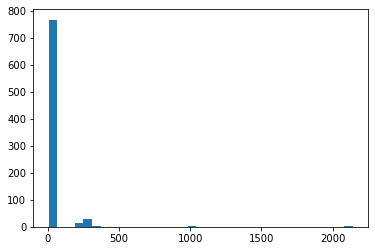

In [21]:
# distribuzione delle differenze
# tra le date dei bollettini
plt.hist(df.gg.dt.days, bins=35)
plt.show()

In [22]:
ggdf = df[["data", "gg"]].set_index("data")
ggdf["gg"] = ggdf.gg.dt.days
ggdf.groupby("data").min().value_counts()

gg 
7      139
14       4
6        3
8        3
245      2
5        1
11       1
28       1
29       1
35       1
209      1
231      1
241      1
259      1
275      1
278      1
dtype: int64

In [23]:
# osservazioni totali
df.data.unique().size

162

In [24]:
# caricamento dati meteo

# per ogni regione
for r in df.regione.unique():
    # per ogni anno
    for y in df.year.unique():
        wname = f"{base_dir}/{y}/dati/weather/regioni/weather_{y}.csv"
        w = pd.read_csv(wname, parse_dates=["date_time"])
        # rinomina colonne per uniformare a dataset West-Nile
        w.columns = w.columns.str.replace("date_time", "data")
        w.columns = w.columns.str.replace("location", "regione")
        # rinomina regioni per uniformare a dataset West-Nile
        w["regione"] = w.regione.str.lower()
        w["regione"] = w.regione.str.replace(r'^friuli$', "friuli-venezia giulia", regex=True)
        
        # sub-dataset del definitivo per regione e anno in corso
        _df = df[(df.regione==r)&(df.year==y)]
        
        # per ogni data di riferimento
        for data in _df.data.values:
            for lag in lags:
                # definisci la data precedente
                #wmin = _df[_df.data==wmax].wmin.values[0]
                # lag week
                wmax = data - pd.Timedelta(days=7*lag)
                wmin = data - pd.Timedelta(days=7*lag+6)
                # sub-dataset meteo entro le date di riferimento
                _w = w[(w.data>=wmin)&(w.data<=wmax)&(w.regione==r)]
                if r not in _w.regione.unique():
                    # errore di dati meteo non disponibili
                    print("ERRORE", r, y, wmin, wmax)
                    print(w.regione.unique())

                # dati meteo
                # temperatura media settimanale
                temp = _w.tempC.mean()
                # vento medio settimanale
                wind_speed = _w.windspeedKmph.mean()
                # somma delle precipitazioni settimanali
                precip = _w.precipMM.sum()

                # aggiungi i dati meteo al dataframe definitivo
                df.loc[(df.regione==r)&(df.data==wmax), f"temp_{lag}"] = temp
                df.loc[(df.regione==r)&(df.data==wmax), f"prec_{lag}"] = precip
                df.loc[(df.regione==r)&(df.data==wmax), f"wind_{lag}"] = wind_speed

ERRORE sardegna 2012 2012-09-14 00:00:00 2012-09-20 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-07 00:00:00 2012-09-13 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-08-31 00:00:00 2012-09-06 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-14 00:00:00 2012-09-20 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-07 00:00:00 2012-09-13 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-20 00:00:00 2012-09-26 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-13 00:00:00 2012-09-19 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2012 2012-09-20 00:00:00 2012-09-26 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE sardegna 2017 2017-07-20 00:00:00

ERRORE veneto 2012 2012-09-14 00:00:00 2012-09-20 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-07 00:00:00 2012-09-13 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-08-31 00:00:00 2012-09-06 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-14 00:00:00 2012-09-20 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-07 00:00:00 2012-09-13 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-20 00:00:00 2012-09-26 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-13 00:00:00 2012-09-19 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2012 2012-09-20 00:00:00 2012-09-26 00:00:00
['basilicata' 'sardegna' 'veneto' 'friuli-venezia giulia']
ERRORE veneto 2013 2013-08-23 00:00:00 2013-08-29 00:00:

ERRORE emilia-romagna 2016 2016-07-15 00:00:00 2016-07-21 00:00:00
['emilia-romagna' 'lombardia' 'piemonte' 'sicilia' 'veneto']
ERRORE emilia-romagna 2016 2016-07-08 00:00:00 2016-07-14 00:00:00
['emilia-romagna' 'lombardia' 'piemonte' 'sicilia' 'veneto']
ERRORE emilia-romagna 2016 2016-07-01 00:00:00 2016-07-07 00:00:00
['emilia-romagna' 'lombardia' 'piemonte' 'sicilia' 'veneto']
ERRORE emilia-romagna 2017 2017-07-20 00:00:00 2017-07-26 00:00:00
['emilia-romagna' 'lazio' 'lombardia' 'piemonte' 'sardegna' 'toscana'
 'veneto']
ERRORE emilia-romagna 2017 2017-07-13 00:00:00 2017-07-19 00:00:00
['emilia-romagna' 'lazio' 'lombardia' 'piemonte' 'sardegna' 'toscana'
 'veneto']
ERRORE emilia-romagna 2017 2017-07-06 00:00:00 2017-07-12 00:00:00
['emilia-romagna' 'lazio' 'lombardia' 'piemonte' 'sardegna' 'toscana'
 'veneto']
ERRORE emilia-romagna 2017 2017-07-21 00:00:00 2017-07-27 00:00:00
['emilia-romagna' 'lazio' 'lombardia' 'piemonte' 'sardegna' 'toscana'
 'veneto']
ERRORE emilia-romagna 20

ERRORE lombardia 2013 2013-08-23 00:00:00 2013-08-29 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2013 2013-08-16 00:00:00 2013-08-22 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2013 2013-08-09 00:00:00 2013-08-15 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2013 2013-08-23 00:00:00 2013-08-29 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2013 2013-08-16 00:00:00 2013-08-22 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2013 2013-08-23 00:00:00 2013-08-29 00:00:00
['emilia-romagna' 'lombardia' 'puglia' 'veneto']
ERRORE lombardia 2014 2014-08-20 00:00:00 2014-08-26 00:00:00
['emilia-romagna' 'lombardia' 'veneto']
ERRORE lombardia 2014 2014-08-13 00:00:00 2014-08-19 00:00:00
['emilia-romagna' 'lombardia' 'veneto']
ERRORE lombardia 2014 2014-08-06 00:00:00 2014-08-12 00:00:00
['emilia-romagna' 'lombardia' 'veneto']
ERRORE lombardia 2014 2014-0

ERRORE piemonte 2022 2022-06-29 00:00:00 2022-07-05 00:00:00
['veneto' 'toscana' 'sicilia' 'sardegna' 'piemonte' 'lombardia'
 'friuli-venezia giulia' 'emilia-romagna']
ERRORE liguria 2021 2021-07-08 00:00:00 2021-07-14 00:00:00
['emilia-romagna' 'friuli-venezia giulia' 'liguria' 'lombardia' 'piemonte'
 'sardegna' 'veneto']
ERRORE liguria 2021 2021-07-01 00:00:00 2021-07-07 00:00:00
['emilia-romagna' 'friuli-venezia giulia' 'liguria' 'lombardia' 'piemonte'
 'sardegna' 'veneto']
ERRORE liguria 2021 2021-06-24 00:00:00 2021-06-30 00:00:00
['emilia-romagna' 'friuli-venezia giulia' 'liguria' 'lombardia' 'piemonte'
 'sardegna' 'veneto']
ERRORE liguria 2021 2021-07-08 00:00:00 2021-07-14 00:00:00
['emilia-romagna' 'friuli-venezia giulia' 'liguria' 'lombardia' 'piemonte'
 'sardegna' 'veneto']
ERRORE liguria 2021 2021-07-01 00:00:00 2021-07-07 00:00:00
['emilia-romagna' 'friuli-venezia giulia' 'liguria' 'lombardia' 'piemonte'
 'sardegna' 'veneto']
ERRORE campania 2022 2022-09-28 00:00:00 2022-1

In [25]:
# osservazioni totali
df[~df["wind_3"].isna()].data.unique().size

108

In [26]:
# colonne del dataframe
df.columns

Index(['data', 'regione', 'nuovi_sorveglianza_entomologica',
       'nuovi_sorveglianza_equidi', 'nuovi_sorveglianza_uccelli_bersaglio',
       'nuovi_sorveglianza_uccelli_selvatici', 'nuovi_sorveglianza_umana',
       'gg', 'year', 'temp_1', 'prec_1', 'wind_1', 'temp_2', 'prec_2',
       'wind_2', 'temp_3', 'prec_3', 'wind_3'],
      dtype='object')

In [27]:
# definizione variabili dipendenti
Ys = df.columns[2:7]
Ys

Index(['nuovi_sorveglianza_entomologica', 'nuovi_sorveglianza_equidi',
       'nuovi_sorveglianza_uccelli_bersaglio',
       'nuovi_sorveglianza_uccelli_selvatici', 'nuovi_sorveglianza_umana'],
      dtype='object')

# Database description

In [28]:
# regioni nel dataframe
", ".join(np.sort(df.regione.unique()))

'basilicata, campania, emilia-romagna, friuli-venezia giulia, lazio, liguria, lombardia, marche, molise, piemonte, puglia, sardegna, sicilia, toscana, veneto'

In [29]:
# numero regioni nel dataframe
np.sort(df.regione.unique()).size

15

In [30]:
# informazioni generali
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype          
---  ------                                --------------  -----          
 0   data                                  819 non-null    datetime64[ns] 
 1   regione                               819 non-null    object         
 2   nuovi_sorveglianza_entomologica       439 non-null    float64        
 3   nuovi_sorveglianza_equidi             318 non-null    float64        
 4   nuovi_sorveglianza_uccelli_bersaglio  348 non-null    float64        
 5   nuovi_sorveglianza_uccelli_selvatici  283 non-null    float64        
 6   nuovi_sorveglianza_umana              674 non-null    float64        
 7   gg                                    819 non-null    timedelta64[ns]
 8   year                                  819 non-null    int64          
 9   temp_1                                650 non-null    float64    

In [31]:
# primo anno di pubblicazione del tipo di variabile West-Nile
min_years = {}
for Y in Ys:
    min_year = df[~df[Y].isna()].data.dt.year.values[0]
    min_years.update({Y: min_year})
min_years

{'nuovi_sorveglianza_entomologica': 2017,
 'nuovi_sorveglianza_equidi': 2017,
 'nuovi_sorveglianza_uccelli_bersaglio': 2017,
 'nuovi_sorveglianza_uccelli_selvatici': 2017,
 'nuovi_sorveglianza_umana': 2012}

In [32]:
# imputa a zero (nessun nuovo caso) le osservazioni mancanti
for y in Ys:
    df[y] = df[y].fillna(0)

In [33]:
# visualizza eventuali dati negativi
for Y in Ys:
    display(df[df[Y]<0][["data", "regione", Y]])

,data,regione,nuovi_sorveglianza_entomologica
733,2022-08-23,emilia-romagna,-4.0
777,2022-10-04,piemonte,-1.0


,data,regione,nuovi_sorveglianza_equidi
338,2018-09-19,piemonte,-3.0
804,2022-10-25,veneto,-1.0


,data,regione,nuovi_sorveglianza_uccelli_bersaglio
365,2018-10-10,piemonte,-1.0


,data,regione,nuovi_sorveglianza_uccelli_selvatici


,data,regione,nuovi_sorveglianza_umana
792,2022-10-18,emilia-romagna,-1.0


In [34]:
# imputa a zero i dati negativi
for Y in Ys:
    df.loc[df[Y]<0, Y] = 0

In [35]:
# verifica
for Y in Ys:
    display(df[df[Y]<0][["data", "regione", Y]])

,data,regione,nuovi_sorveglianza_entomologica


,data,regione,nuovi_sorveglianza_equidi


,data,regione,nuovi_sorveglianza_uccelli_bersaglio


,data,regione,nuovi_sorveglianza_uccelli_selvatici


,data,regione,nuovi_sorveglianza_umana


In [36]:
# qualche controllo grafico delle variabili

<AxesSubplot:xlabel='data'>

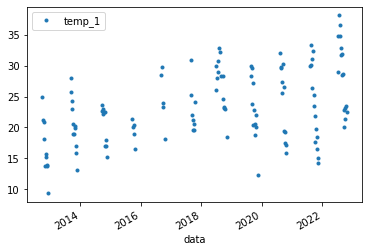

In [37]:
df[df.regione=="veneto"].plot(x="data", y="temp_1", marker=".", ls="none")

<AxesSubplot:xlabel='data'>

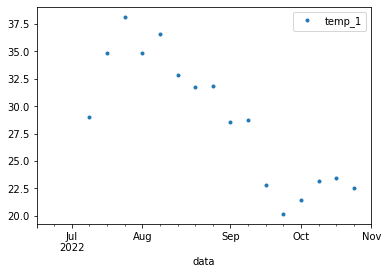

In [38]:
df[(df.regione=="veneto")&(df.year==2022)].plot(x="data", y="temp_1", marker=".", ls="none")

<AxesSubplot:xlabel='data'>

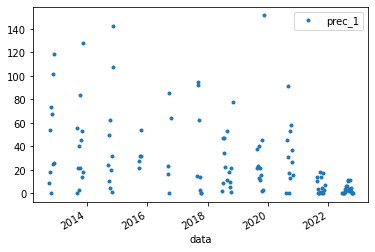

In [39]:
df[df.regione=="veneto"].plot(x="data", y="prec_1", marker=".", ls="none")

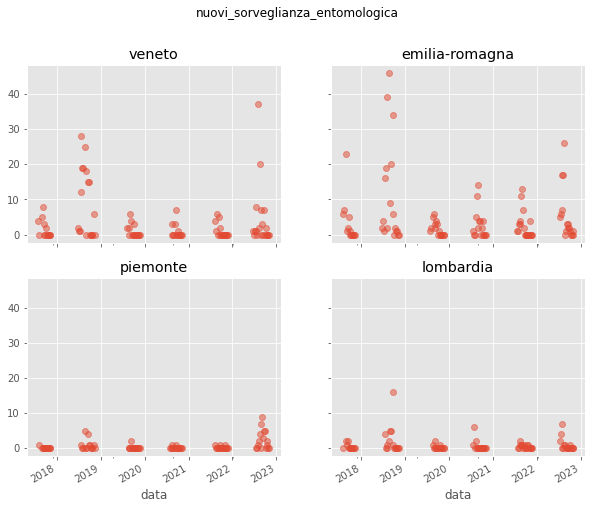

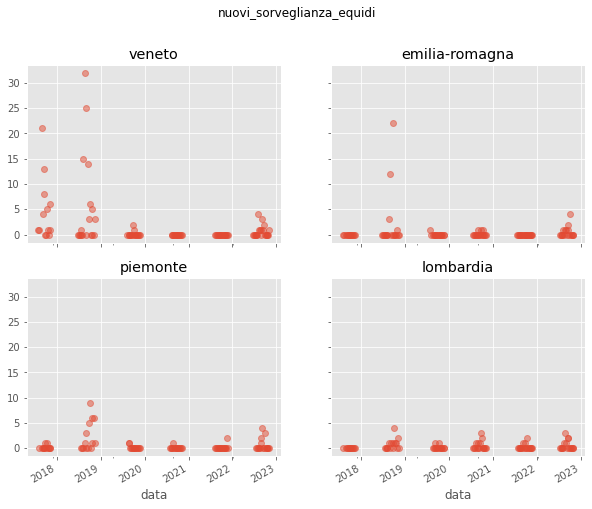

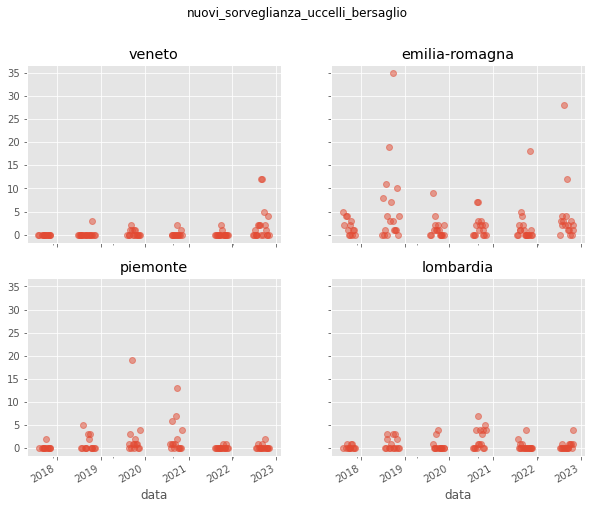

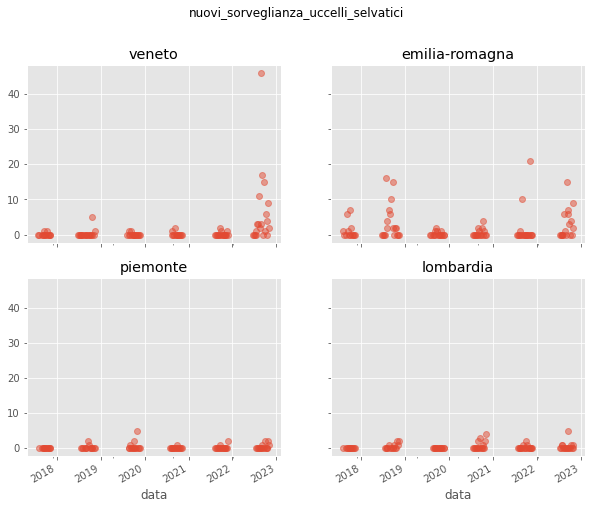

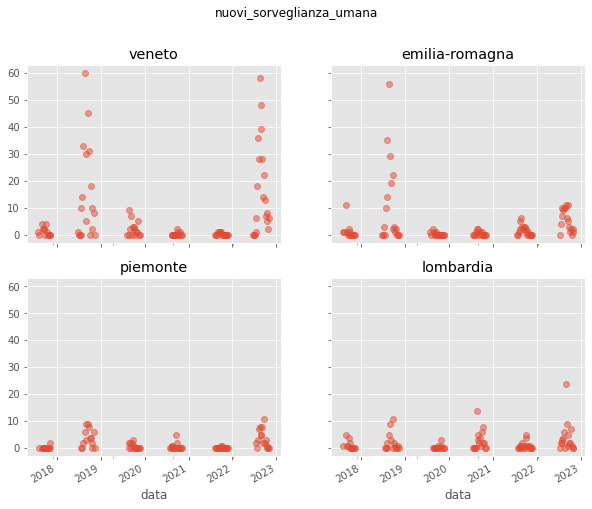

In [40]:
for Y in Ys:
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey=True, sharex=True)
        for i, r in enumerate(["veneto", "emilia-romagna", "piemonte", "lombardia"]):
            df[(df.regione==r)&(df.year>=2017)].plot(
                x="data", y=Y, marker="o", ls="none",
                ax=ax.flat[i],
                title=r, alpha=.5, legend=False
            )
        fig.suptitle(Y)
        plt.show()

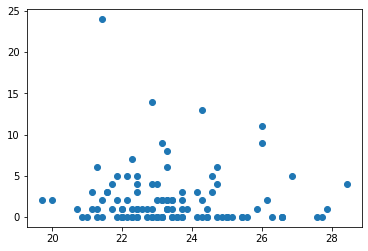

In [41]:
plt.plot(
    df[(df.regione=="lombardia")]["temp_1"].values,
    df[(df.regione=="lombardia")].nuovi_sorveglianza_umana.values,
    marker="o", ls="none"
)

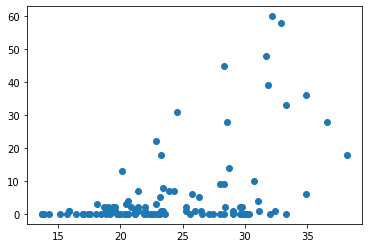

In [42]:
plt.plot(
    df[(df.regione=="veneto")]["temp_2"].values,
    df[(df.regione=="veneto")].nuovi_sorveglianza_umana.values,
    marker="o", ls="none"
)

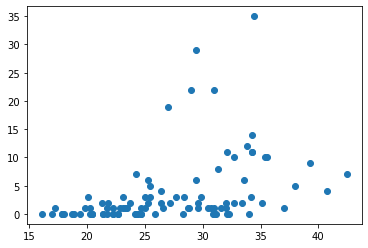

In [43]:
plt.plot(
    df[(df.regione=="emilia-romagna")]["temp_3"].values,
    df[(df.regione=="emilia-romagna")].nuovi_sorveglianza_umana.values,
    marker="o", ls="none"
)

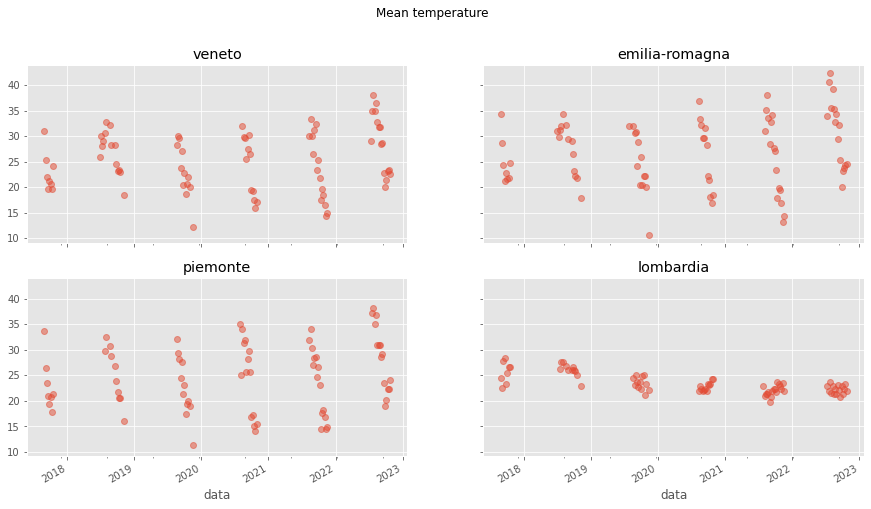

In [44]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey=True, sharex=True)
    for i, r in enumerate(["veneto", "emilia-romagna", "piemonte", "lombardia"]):
        df[(df.regione==r)&(df.year>=2017)].plot(
            x="data", y="temp_1", marker="o", ls="none",
            ax=ax.flat[i],
            title=r, alpha=.5, legend=False
        )
    fig.suptitle("Mean temperature")

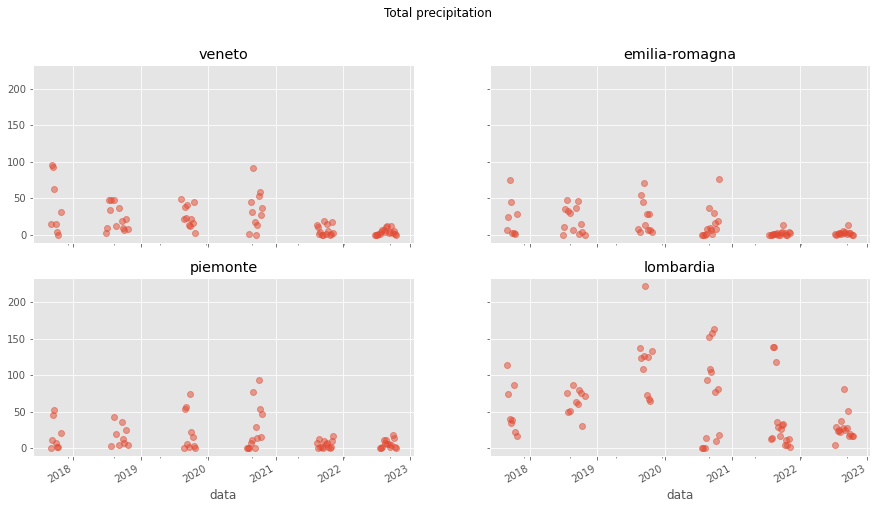

In [45]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey=True, sharex=True)
    for i, r in enumerate(["veneto", "emilia-romagna", "piemonte", "lombardia"]):
        df[(df.regione==r)&(df.year>=2017)].plot(
            x="data", y="prec_2", marker="o", ls="none",
            ax=ax.flat[i],
            title=r, alpha=.5, legend=False
        )
    fig.suptitle("Total precipitation")

# New (regions)

In [46]:
# settimana di riferimento
df["week"] = df.data.dt.isocalendar().week.astype(int)

In [47]:
def regional_regression_reg(df, Y, covariates, regions=None, results=None, 
                            infl_week=None, lag=1, min_year=None, title=None, CI=.95):
    """
    Zero-inflated Poisson regression
    """
    lagged_covariates = []
    for cov in covariates:
        lagged_covariates.append(f"{cov}_{lag}")
    # variabili meteo
    cov_formula = " + ".join(lagged_covariates)
    # formula completa della regressione
    formula = f"{Y} ~ {cov_formula} + regione + {lagged_covariates[0]}*regione + week"
    # la settimana "week" sarà poi eclusa dalla regressione Poisson
    # e usata solamente per la parte Logit della ZIP regression
    
    # nome della variabile output
    y = None
    if "umana" in Y:
        y = "human"
    if "equidi" in Y:
        y = "equids"
    if "bersaglio" in Y:
        y = "target birds"
    if "selvatici" in Y:
        y = "wild birds"
    if "entomo" in Y:
        y = "entomological"
    
    print()
    print("##################################################################")
    print(formula, f"lag={lag}", f"min_year={min_year}")
    print("##################################################################")
    
    # solo i dati relativi alle regioni scelte e in cui la differenza
    # tra i bollettini è esattamente 7 giorni per 3 volte consecutive
    DF = df[
        (df.regione.isin(regions))
        #&
        #(df.gg==gg7)
        #&
        #(df.gg1==gg7)
        #&
        #(df.gg2==gg7)
        #&
        #(df.gg3==gg7)
    ].copy(deep=True)

    # se c'è un anno minimo, escludi i precedenti
    if min_year is not None:
        DF = DF[DF.year>=min_year]
    # sposta le variabili meteo di "lag" settimane
    #shifted = DF[covariates].shift(lag)
    #DF[covariates] = shifted
    
    # TEST STANDARDIZZAZIONE
    # TODO: ???
    # standardize
    #DF[covariates] = (DF[covariates] - DF[covariates].mean())/DF[covariates].std()
    #DF[Y] = (DF[Y] - DF[Y].mean())/DF[Y].std()

    # se meno di venti osservazioni, evita la regressione
    if DF.index.size < 20:
        print(f"{r}: not enough observations ({DF.index.size})")
        return None

    # variabile dipendente e variabili indipendenti come definite nella formula
    y_train, X_train = dmatrices(formula, DF, return_type='dataframe')
    # escludi il numero di settimana dalle indipendenti
    X_ok = X_train.loc[:, ~X_train.columns.isin(["week"])]
    # definisci la variabile esplicativa della parte logit
    X_infl = X_train[["week"]].copy(deep=True)
    X_infl["Intercept"] = 1.0
    # modello ZIP
    mod = sm.ZeroInflatedPoisson(endog=y_train, exog=X_ok, 
                                 exog_infl=X_infl, 
                                 inflation='logit')
    fit = mod.fit(maxiter=1000)
    # sunto
    display(fit.summary())

    # intervallo confidenza dei coefficienti
    alpha = (1 - CI)/2
    pci = fit.conf_int(alpha=alpha)
    
    # aggiungi i risultati
    # modello
    results["model"].append(fit)
    # variabile dipendente
    results["Y"].append(y)
    # lag considerato
    results["lag"].append(lag)
    # R-quadrato
    results["R2"].append(np.round(fit.prsquared, 3))
    # temperatura
    results["temp"].append(np.round(fit.params[lagged_covariates[0]], 3))
    results["temp lo"].append(np.round(pci[pci.index==lagged_covariates[0]][0].values[0], 3))
    results["temp up"].append(np.round(pci[pci.index==lagged_covariates[0]][1].values[0], 3))
    results["temp p-val"].append(np.round(fit.pvalues[lagged_covariates[0]], 3))
    # precipitazioni
    results["prec"].append(np.round(fit.params[lagged_covariates[1]], 3))
    results["prec lo"].append(np.round(pci[pci.index==lagged_covariates[1]][0].values[0], 3))
    results["prec up"].append(np.round(pci[pci.index==lagged_covariates[1]][1].values[0], 3))
    results["prec p-val"].append(np.round(fit.pvalues[lagged_covariates[1]], 3))
    # inflate week
    infl_week["Y"].append(y)
    infl_week["lag"].append(lag)
    infl_week["mu"].append(np.round(fit.params["inflate_week"], 3))
    infl_week["lo"].append(np.round(pci[pci.index=="inflate_week"][0].values[0], 3))
    infl_week["up"].append(np.round(pci[pci.index=="inflate_week"][1].values[0], 3))
    infl_week["pv"].append(np.round(fit.pvalues["inflate_week"], 3))

    return results, infl_week

In [48]:
# definizione variabili indipendenti
covariates = ["temp", "prec"]#, "wind"]

In [49]:
# inizializza i risultati della regressione ZIP
results = {
    "model": [],
    "Y": [],
    "lag": [],
    "R2": [],
    "temp": [],
    "temp lo": [],
    "temp up": [],
    "temp p-val": [],
    "prec": [],
    "prec lo": [],
    "prec up": [],
    "prec p-val": [],
}
infl_week = {
    "Y": [],
    "lag": [],
    "mu": [],
    "lo": [],
    "up": [],
    "pv": [],
}

# per ogni variabile dipendente
for Y in Ys:
    # per ogni lag
    for lag in lags:
        # regressione ZIP        # escludo il vento: HA SENSO COI LAG...???
        results, infl_week = regional_regression_reg(df, Y, covariates, 
                                      # regioni più colpite
                                      # dato che la Lombardia ha un profilo di temperatura
                                      # molto diverso dalle altre, è stato aggiunto un termine
                                      # di interazione nella formula della regressione    
                                      regions=["veneto", "emilia-romagna", "piemonte", "lombardia"],
                                      results=results, infl_week=infl_week, lag=lag, CI=.99)


##################################################################
nuovi_sorveglianza_entomologica ~ temp_1 + prec_1 + regione + temp_1*regione + week lag=1 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.717522
         Iterations: 67
         Function evaluations: 74
         Gradient evaluations: 74


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           ZeroInflatedPoisson Regression Results                          
===========================================================================================
Dep. Variable:     nuovi_sorveglianza_entomologica   No. Observations:                  423
Model:                         ZeroInflatedPoisson   Df Residuals:                      414
Method:                                        MLE   Df Model:                            8
Date:                             Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2195
Time:                                     19:03:02   Log-Likelihood:                -726.51
converged:                                    True   LL-Null:                       -930.77
Covariance Type:                         nonrobust   LLR p-value:                 2.825e-83
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.3322      0.040      8.224      0.000       0.253       0.411
inflate_Intercept             -12.0339      1.537     -7.829      0.000     -15.046      -9.021
Intercept                      -0.8264      0.339     -2.439      0.015      -1.491      -0.162
regione[T.lombardia]           -2.8321      1.590     -1.782      0.075      -5.948       0.284
regione[T.piemonte]             1.7218      0.800      2.152      0.031       0.154       3.290
regione[T.veneto]              -0.7220      0.583     -1.239      0.215      -1.864       0.420
temp_1                          0.0871      0.010      8.565      0.000       0.067       0.107
temp_1:regione[T.lombardia]     0.0737      0.065      1.142      0.253      -0.053       0.200
temp_1:regione[T.piemonte]     -0.0950      0.029     -3.328      0.001      -0.151      -0.039
temp_1:regione[T.veneto]        0.0300      0.019      1.602      0.109      -0.007       0.067
prec_1                          0.0074      0.002      3.982      0.000       0.004       0.011
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_entomologica ~ temp_2 + prec_2 + regione + temp_2*regione + week lag=2 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.944411
         Iterations: 67
         Function evaluations: 74
         Gradient evaluations: 74


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           ZeroInflatedPoisson Regression Results                          
===========================================================================================
Dep. Variable:     nuovi_sorveglianza_entomologica   No. Observations:                  383
Model:                         ZeroInflatedPoisson   Df Residuals:                      374
Method:                                        MLE   Df Model:                            8
Date:                             Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2249
Time:                                     19:03:02   Log-Likelihood:                -744.71
converged:                                    True   LL-Null:                       -960.85
Covariance Type:                         nonrobust   LLR p-value:                 2.319e-88
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.3491      0.045      7.845      0.000       0.262       0.436
inflate_Intercept             -12.6913      1.686     -7.527      0.000     -15.996      -9.387
Intercept                      -0.7509      0.321     -2.343      0.019      -1.379      -0.123
regione[T.lombardia]           -3.4888      1.659     -2.103      0.035      -6.740      -0.238
regione[T.piemonte]             2.2059      0.839      2.628      0.009       0.561       3.851
regione[T.veneto]              -0.8617      0.578     -1.490      0.136      -1.995       0.272
temp_2                          0.0881      0.010      9.182      0.000       0.069       0.107
temp_2:regione[T.lombardia]     0.0940      0.068      1.387      0.165      -0.039       0.227
temp_2:regione[T.piemonte]     -0.1153      0.030     -3.870      0.000      -0.174      -0.057
temp_2:regione[T.veneto]        0.0302      0.019      1.616      0.106      -0.006       0.067
prec_2                          0.0087      0.002      5.107      0.000       0.005       0.012
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_entomologica ~ temp_3 + prec_3 + regione + temp_3*regione + week lag=3 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.951136
         Iterations: 62
         Function evaluations: 71
         Gradient evaluations: 71


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           ZeroInflatedPoisson Regression Results                          
===========================================================================================
Dep. Variable:     nuovi_sorveglianza_entomologica   No. Observations:                  354
Model:                         ZeroInflatedPoisson   Df Residuals:                      345
Method:                                        MLE   Df Model:                            8
Date:                             Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2069
Time:                                     19:03:03   Log-Likelihood:                -690.70
converged:                                    True   LL-Null:                       -870.91
Covariance Type:                         nonrobust   LLR p-value:                 5.405e-73
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.3385      0.046      7.340      0.000       0.248       0.429
inflate_Intercept             -12.3277      1.740     -7.083      0.000     -15.739      -8.916
Intercept                      -0.9469      0.344     -2.751      0.006      -1.622      -0.272
regione[T.lombardia]           -3.7492      1.551     -2.418      0.016      -6.789      -0.710
regione[T.piemonte]             2.6405      0.866      3.051      0.002       0.944       4.337
regione[T.veneto]              -0.7558      0.593     -1.274      0.203      -1.918       0.407
temp_3                          0.0888      0.010      8.602      0.000       0.069       0.109
temp_3:regione[T.lombardia]     0.1101      0.062      1.767      0.077      -0.012       0.232
temp_3:regione[T.piemonte]     -0.1282      0.031     -4.165      0.000      -0.189      -0.068
temp_3:regione[T.veneto]        0.0304      0.019      1.592      0.111      -0.007       0.068
prec_3                          0.0100      0.002      5.741      0.000       0.007       0.013
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_equidi ~ temp_1 + prec_1 + regione + temp_1*regione + week lag=1 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 0.921002
         Iterations: 71
         Function evaluations: 84
         Gradient evaluations: 76


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        ZeroInflatedPoisson Regression Results                       
=====================================================================================
Dep. Variable:     nuovi_sorveglianza_equidi   No. Observations:                  423
Model:                   ZeroInflatedPoisson   Df Residuals:                      414
Method:                                  MLE   Df Model:                            8
Date:                       Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1227
Time:                               19:03:03   Log-Likelihood:                -389.58
converged:                              True   LL-Null:                       -444.07
Covariance Type:                   nonrobust   LLR p-value:                 6.180e-20
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0937      0.030      3.073      0.002       0.034       0.153
inflate_Intercept              -2.0971      1.156     -1.814      0.070      -4.363       0.169
Intercept                       2.6057      1.011      2.577      0.010       0.624       4.587
regione[T.lombardia]           -3.2875      2.805     -1.172      0.241      -8.786       2.210
regione[T.piemonte]            -0.4462      1.197     -0.373      0.709      -2.792       1.899
regione[T.veneto]              -2.6453      1.158     -2.283      0.022      -4.916      -0.375
temp_1                         -0.0484      0.034     -1.402      0.161      -0.116       0.019
temp_1:regione[T.lombardia]     0.0570      0.117      0.487      0.626      -0.172       0.286
temp_1:regione[T.piemonte]     -0.0117      0.044     -0.266      0.790      -0.098       0.075
temp_1:regione[T.veneto]        0.1078      0.040      2.715      0.007       0.030       0.186
prec_1                          0.0096      0.002      4.195      0.000       0.005       0.014
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_equidi ~ temp_2 + prec_2 + regione + temp_2*regione + week lag=2 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 0.997835
         Iterations: 67
         Function evaluations: 75
         Gradient evaluations: 75


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        ZeroInflatedPoisson Regression Results                       
=====================================================================================
Dep. Variable:     nuovi_sorveglianza_equidi   No. Observations:                  383
Model:                   ZeroInflatedPoisson   Df Residuals:                      374
Method:                                  MLE   Df Model:                            8
Date:                       Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1631
Time:                               19:03:03   Log-Likelihood:                -382.17
converged:                              True   LL-Null:                       -456.65
Covariance Type:                   nonrobust   LLR p-value:                 3.227e-28
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0907      0.033      2.738      0.006       0.026       0.156
inflate_Intercept              -2.0236      1.246     -1.625      0.104      -4.465       0.418
Intercept                       1.6454      1.137      1.447      0.148      -0.583       3.873
regione[T.lombardia]           -2.2982      2.787     -0.824      0.410      -7.761       3.165
regione[T.piemonte]             1.5580      1.378      1.131      0.258      -1.143       4.259
regione[T.veneto]              -1.2272      1.234     -0.994      0.320      -3.646       1.191
temp_2                         -0.0238      0.039     -0.613      0.540      -0.100       0.052
temp_2:regione[T.lombardia]     0.0301      0.115      0.262      0.793      -0.195       0.255
temp_2:regione[T.piemonte]     -0.0747      0.051     -1.468      0.142      -0.175       0.025
temp_2:regione[T.veneto]        0.0736      0.042      1.742      0.081      -0.009       0.156
prec_2                          0.0094      0.002      4.322      0.000       0.005       0.014
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_equidi ~ temp_3 + prec_3 + regione + temp_3*regione + week lag=3 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.016840
         Iterations: 68
         Function evaluations: 81
         Gradient evaluations: 73


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                        ZeroInflatedPoisson Regression Results                       
=====================================================================================
Dep. Variable:     nuovi_sorveglianza_equidi   No. Observations:                  354
Model:                   ZeroInflatedPoisson   Df Residuals:                      345
Method:                                  MLE   Df Model:                            8
Date:                       Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1281
Time:                               19:03:03   Log-Likelihood:                -359.96
converged:                              True   LL-Null:                       -412.86
Covariance Type:                   nonrobust   LLR p-value:                 2.775e-19
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0598      0.035      1.718      0.086      -0.008       0.128
inflate_Intercept              -0.9120      1.304     -0.700      0.484      -3.467       1.643
Intercept                       1.8083      1.005      1.799      0.072      -0.162       3.779
regione[T.lombardia]           -3.4853      3.098     -1.125      0.261      -9.557       2.586
regione[T.piemonte]             1.4240      1.299      1.096      0.273      -1.122       3.970
regione[T.veneto]              -1.1291      1.145     -0.987      0.324      -3.372       1.114
temp_3                         -0.0244      0.034     -0.707      0.480      -0.092       0.043
temp_3:regione[T.lombardia]     0.0672      0.130      0.517      0.605      -0.188       0.322
temp_3:regione[T.piemonte]     -0.0730      0.049     -1.498      0.134      -0.168       0.023
temp_3:regione[T.veneto]        0.0548      0.040      1.385      0.166      -0.023       0.132
prec_3                          0.0117      0.002      5.301      0.000       0.007       0.016
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_bersaglio ~ temp_1 + prec_1 + regione + temp_1*regione + week lag=1 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.506382
         Iterations: 62
         Function evaluations: 73
         Gradient evaluations: 73


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_bersaglio   No. Observations:                  423
Model:                              ZeroInflatedPoisson   Df Residuals:                      414
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                 0.05627
Time:                                          19:03:03   Log-Likelihood:                -637.20
converged:                                         True   LL-Null:                       -675.19
Covariance Type:                              nonrobust   LLR p-value:                 3.135e-13
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0917      0.026      3.500      0.000       0.040       0.143
inflate_Intercept              -2.8196      1.000     -2.819      0.005      -4.780      -0.859
Intercept                       0.5103      0.340      1.499      0.134      -0.157       1.178
regione[T.lombardia]           -0.4209      2.004     -0.210      0.834      -4.349       3.507
regione[T.piemonte]             0.4278      0.608      0.704      0.481      -0.763       1.618
regione[T.veneto]              -2.1864      0.856     -2.556      0.011      -3.863      -0.510
temp_1                          0.0318      0.011      2.900      0.004       0.010       0.053
temp_1:regione[T.lombardia]    -0.0181      0.085     -0.212      0.832      -0.185       0.149
temp_1:regione[T.piemonte]     -0.0296      0.023     -1.300      0.193      -0.074       0.015
temp_1:regione[T.veneto]        0.0608      0.029      2.093      0.036       0.004       0.118
prec_1                          0.0039      0.002      2.151      0.032       0.000       0.007
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_bersaglio ~ temp_2 + prec_2 + regione + temp_2*regione + week lag=2 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.608994
         Iterations: 67
         Function evaluations: 74
         Gradient evaluations: 74


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_bersaglio   No. Observations:                  383
Model:                              ZeroInflatedPoisson   Df Residuals:                      374
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                 0.05867
Time:                                          19:03:03   Log-Likelihood:                -616.24
converged:                                         True   LL-Null:                       -654.66
Covariance Type:                              nonrobust   LLR p-value:                 2.127e-13
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0801      0.029      2.808      0.005       0.024       0.136
inflate_Intercept              -2.4442      1.077     -2.269      0.023      -4.556      -0.333
Intercept                       0.8106      0.329      2.466      0.014       0.166       1.455
regione[T.lombardia]           -1.0485      2.322     -0.452      0.652      -5.599       3.502
regione[T.piemonte]             0.1204      0.587      0.205      0.838      -1.030       1.271
regione[T.veneto]              -2.5404      0.897     -2.832      0.005      -4.298      -0.783
temp_2                          0.0235      0.011      2.201      0.028       0.003       0.044
temp_2:regione[T.lombardia]    -0.0032      0.100     -0.032      0.975      -0.199       0.192
temp_2:regione[T.piemonte]     -0.0195      0.022     -0.902      0.367      -0.062       0.023
temp_2:regione[T.veneto]        0.0700      0.030      2.307      0.021       0.011       0.129
prec_2                          0.0047      0.002      2.564      0.010       0.001       0.008
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_bersaglio ~ temp_3 + prec_3 + regione + temp_3*regione + week lag=3 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.628648
         Iterations: 64
         Function evaluations: 71
         Gradient evaluations: 71


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_bersaglio   No. Observations:                  354
Model:                              ZeroInflatedPoisson   Df Residuals:                      345
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                 0.04941
Time:                                          19:03:03   Log-Likelihood:                -576.54
converged:                                         True   LL-Null:                       -606.51
Covariance Type:                              nonrobust   LLR p-value:                 4.787e-10
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0823      0.031      2.685      0.007       0.022       0.142
inflate_Intercept              -2.5311      1.146     -2.209      0.027      -4.777      -0.285
Intercept                       1.2550      0.366      3.428      0.001       0.538       1.973
regione[T.lombardia]           -1.1268      2.064     -0.546      0.585      -5.172       2.919
regione[T.piemonte]             0.1048      0.626      0.167      0.867      -1.122       1.331
regione[T.veneto]              -2.6854      0.909     -2.954      0.003      -4.467      -0.903
temp_3                          0.0065      0.012      0.547      0.585      -0.017       0.030
temp_3:regione[T.lombardia]    -0.0005      0.088     -0.006      0.995      -0.173       0.172
temp_3:regione[T.piemonte]     -0.0165      0.023     -0.720      0.472      -0.061       0.028
temp_3:regione[T.veneto]        0.0776      0.031      2.511      0.012       0.017       0.138
prec_3                          0.0041      0.002      2.216      0.027       0.000       0.008
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_selvatici ~ temp_1 + prec_1 + regione + temp_1*regione + week lag=1 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.103656
         Iterations: 68
         Function evaluations: 78
         Gradient evaluations: 78


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_selvatici   No. Observations:                  423
Model:                              ZeroInflatedPoisson   Df Residuals:                      414
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1116
Time:                                          19:03:03   Log-Likelihood:                -466.85
converged:                                         True   LL-Null:                       -525.49
Covariance Type:                              nonrobust   LLR p-value:                 1.204e-21
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0734      0.029      2.537      0.011       0.017       0.130
inflate_Intercept              -1.6321      1.110     -1.470      0.142      -3.808       0.544
Intercept                       1.4710      0.423      3.476      0.001       0.642       2.300
regione[T.lombardia]            6.3597      3.708      1.715      0.086      -0.907      13.626
regione[T.piemonte]             2.2828      1.293      1.765      0.078      -0.252       4.818
regione[T.veneto]              -1.0962      0.630     -1.740      0.082      -2.331       0.139
temp_1                          0.0092      0.015      0.596      0.551      -0.021       0.039
temp_1:regione[T.lombardia]    -0.3425      0.163     -2.104      0.035      -0.662      -0.023
temp_1:regione[T.piemonte]     -0.1630      0.056     -2.902      0.004      -0.273      -0.053
temp_1:regione[T.veneto]        0.0422      0.022      1.919      0.055      -0.001       0.085
prec_1                         -0.0049      0.003     -1.743      0.081      -0.010       0.001
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_selvatici ~ temp_2 + prec_2 + regione + temp_2*regione + week lag=2 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.123741
         Iterations: 69
         Function evaluations: 78
         Gradient evaluations: 78


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_selvatici   No. Observations:                  383
Model:                              ZeroInflatedPoisson   Df Residuals:                      374
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1189
Time:                                          19:03:03   Log-Likelihood:                -430.39
converged:                                         True   LL-Null:                       -488.47
Covariance Type:                              nonrobust   LLR p-value:                 2.059e-21
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0799      0.032      2.497      0.013       0.017       0.143
inflate_Intercept              -1.8710      1.209     -1.548      0.122      -4.240       0.498
Intercept                       1.6038      0.434      3.695      0.000       0.753       2.455
regione[T.lombardia]            7.4288      3.881      1.914      0.056      -0.178      15.036
regione[T.piemonte]             0.7468      1.600      0.467      0.641      -2.390       3.884
regione[T.veneto]              -1.2038      0.662     -1.819      0.069      -2.501       0.093
temp_2                          0.0055      0.016      0.353      0.724      -0.025       0.036
temp_2:regione[T.lombardia]    -0.3961      0.172     -2.298      0.022      -0.734      -0.058
temp_2:regione[T.piemonte]     -0.1185      0.065     -1.810      0.070      -0.247       0.010
temp_2:regione[T.veneto]        0.0440      0.023      1.924      0.054      -0.001       0.089
prec_2                         -0.0027      0.003     -1.003      0.316      -0.008       0.003
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_uccelli_selvatici ~ temp_3 + prec_3 + regione + temp_3*regione + week lag=3 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 1.133124
         Iterations: 69
         Function evaluations: 78
         Gradient evaluations: 78


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ZeroInflatedPoisson Regression Results                             
================================================================================================
Dep. Variable:     nuovi_sorveglianza_uccelli_selvatici   No. Observations:                  354
Model:                              ZeroInflatedPoisson   Df Residuals:                      345
Method:                                             MLE   Df Model:                            8
Date:                                  Thu, 08 Dec 2022   Pseudo R-squ.:                  0.1205
Time:                                          19:03:03   Log-Likelihood:                -401.13
converged:                                         True   LL-Null:                       -456.07
Covariance Type:                              nonrobust   LLR p-value:                 4.020e-20
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0619      0.034      1.804      0.071      -0.005       0.129
inflate_Intercept              -1.2146      1.288     -0.943      0.346      -3.739       1.309
Intercept                       2.6098      0.462      5.650      0.000       1.704       3.515
regione[T.lombardia]            9.1256      4.309      2.118      0.034       0.681      17.571
regione[T.piemonte]            -0.0859      1.581     -0.054      0.957      -3.184       3.012
regione[T.veneto]              -1.8709      0.698     -2.680      0.007      -3.239      -0.502
temp_3                         -0.0338      0.017     -1.961      0.050      -0.068    -2.1e-05
temp_3:regione[T.lombardia]    -0.4779      0.194     -2.470      0.014      -0.857      -0.099
temp_3:regione[T.piemonte]     -0.0843      0.065     -1.293      0.196      -0.212       0.043
temp_3:regione[T.veneto]        0.0730      0.025      2.968      0.003       0.025       0.121
prec_3                         -0.0033      0.003     -1.131      0.258      -0.009       0.002
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_umana ~ temp_1 + prec_1 + regione + temp_1*regione + week lag=1 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 3.016952
         Iterations: 57
         Function evaluations: 66
         Gradient evaluations: 66


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ZeroInflatedPoisson Regression Results                       
====================================================================================
Dep. Variable:     nuovi_sorveglianza_umana   No. Observations:                  423
Model:                  ZeroInflatedPoisson   Df Residuals:                      414
Method:                                 MLE   Df Model:                            8
Date:                      Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2250
Time:                              19:03:03   Log-Likelihood:                -1276.2
converged:                             True   LL-Null:                       -1646.7
Covariance Type:                  nonrobust   LLR p-value:                1.070e-154
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.1297      0.026      5.007      0.000       0.079       0.180
inflate_Intercept              -5.2706      1.012     -5.206      0.000      -7.255      -3.286
Intercept                      -0.8488      0.310     -2.741      0.006      -1.456      -0.242
regione[T.lombardia]            1.3277      0.988      1.344      0.179      -0.608       3.264
regione[T.piemonte]             1.9180      0.593      3.235      0.001       0.756       3.080
regione[T.veneto]              -0.1621      0.373     -0.435      0.663      -0.892       0.568
temp_1                          0.0848      0.010      8.772      0.000       0.066       0.104
temp_1:regione[T.lombardia]    -0.0483      0.041     -1.170      0.242      -0.129       0.033
temp_1:regione[T.piemonte]     -0.0744      0.021     -3.610      0.000      -0.115      -0.034
temp_1:regione[T.veneto]        0.0407      0.012      3.408      0.001       0.017       0.064
prec_1                         -0.0010      0.001     -0.983      0.326      -0.003       0.001
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_umana ~ temp_2 + prec_2 + regione + temp_2*regione + week lag=2 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 3.124530
         Iterations: 57
         Function evaluations: 67
         Gradient evaluations: 67


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ZeroInflatedPoisson Regression Results                       
====================================================================================
Dep. Variable:     nuovi_sorveglianza_umana   No. Observations:                  383
Model:                  ZeroInflatedPoisson   Df Residuals:                      374
Method:                                 MLE   Df Model:                            8
Date:                      Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2348
Time:                              19:03:03   Log-Likelihood:                -1196.7
converged:                             True   LL-Null:                       -1563.9
Covariance Type:                  nonrobust   LLR p-value:                2.789e-153
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.1135      0.028      4.036      0.000       0.058       0.169
inflate_Intercept              -4.6621      1.083     -4.305      0.000      -6.785      -2.540
Intercept                      -0.8392      0.317     -2.647      0.008      -1.461      -0.218
regione[T.lombardia]            2.3700      1.014      2.337      0.019       0.383       4.357
regione[T.piemonte]             1.7495      0.676      2.588      0.010       0.425       3.074
regione[T.veneto]              -0.4671      0.389     -1.200      0.230      -1.230       0.296
temp_2                          0.0863      0.010      8.805      0.000       0.067       0.106
temp_2:regione[T.lombardia]    -0.0939      0.042     -2.218      0.027      -0.177      -0.011
temp_2:regione[T.piemonte]     -0.0731      0.023     -3.164      0.002      -0.118      -0.028
temp_2:regione[T.veneto]        0.0483      0.012      3.907      0.000       0.024       0.072
prec_2                         -0.0013      0.001     -1.301      0.193      -0.003       0.001
===============================================================================================
"""


##################################################################
nuovi_sorveglianza_umana ~ temp_3 + prec_3 + regione + temp_3*regione + week lag=3 min_year=None
##################################################################
Optimization terminated successfully.
         Current function value: 3.109438
         Iterations: 52
         Function evaluations: 62
         Gradient evaluations: 62


/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ZeroInflatedPoisson Regression Results                       
====================================================================================
Dep. Variable:     nuovi_sorveglianza_umana   No. Observations:                  354
Model:                  ZeroInflatedPoisson   Df Residuals:                      345
Method:                                 MLE   Df Model:                            8
Date:                      Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2114
Time:                              19:03:03   Log-Likelihood:                -1100.7
converged:                             True   LL-Null:                       -1395.8
Covariance Type:                  nonrobust   LLR p-value:                2.967e-122
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
inflate_week                    0.0996      0.030      3.334      0.001       0.041       0.158
inflate_Intercept              -4.1526      1.137     -3.653      0.000      -6.381      -1.925
Intercept                      -0.6714      0.322     -2.082      0.037      -1.303      -0.039
regione[T.lombardia]            1.1902      1.015      1.173      0.241      -0.798       3.179
regione[T.piemonte]             1.5911      0.663      2.399      0.016       0.291       2.891
regione[T.veneto]              -0.4025      0.402     -1.002      0.317      -1.190       0.385
temp_3                          0.0782      0.010      7.773      0.000       0.058       0.098
temp_3:regione[T.lombardia]    -0.0443      0.042     -1.051      0.293      -0.127       0.038
temp_3:regione[T.piemonte]     -0.0647      0.023     -2.853      0.004      -0.109      -0.020
temp_3:regione[T.veneto]        0.0465      0.013      3.617      0.000       0.021       0.072
prec_3                       8.021e-05      0.001      0.080      0.936      -0.002       0.002
===============================================================================================
"""

In [50]:
# risultati in dataframe
dfrs = pd.DataFrame(results)
dfrs[dfrs.columns[1:]]

,Y,lag,R2,temp,temp lo,temp up,temp p-val,prec,prec lo,prec up,prec p-val
0,entomological,1,0.219,0.087,0.059,0.116,0.000,0.007,0.002,0.013,0.000
1,entomological,2,0.225,0.088,0.061,0.115,0.000,0.009,0.004,0.013,0.000
2,entomological,3,0.207,0.089,0.060,0.118,0.000,0.010,0.005,0.015,0.000
3,equids,1,0.123,-0.048,-0.145,0.048,0.161,0.010,0.003,0.016,0.000
4,equids,2,0.163,-0.024,-0.133,0.085,0.540,0.009,0.003,0.015,0.000
5,equids,3,0.128,-0.024,-0.121,0.072,0.480,0.012,0.005,0.018,0.000
6,target birds,1,0.056,0.032,0.001,0.063,0.004,0.004,-0.001,0.009,0.032
7,target birds,2,0.059,0.023,-0.006,0.053,0.028,0.005,-0.000,0.010,0.010
8,target birds,3,0.049,0.007,-0.027,0.040,0.585,0.004,-0.001,0.009,0.027
9,wild birds,1,0.112,0.009,-0.034,0.052,0.551,-0.005,-0.013,0.003,0.081


In [51]:
Latex(dfrs[dfrs.columns[1:]].to_latex(index=False))

<IPython.core.display.Latex object>

In [52]:
colors = "rgbmk"

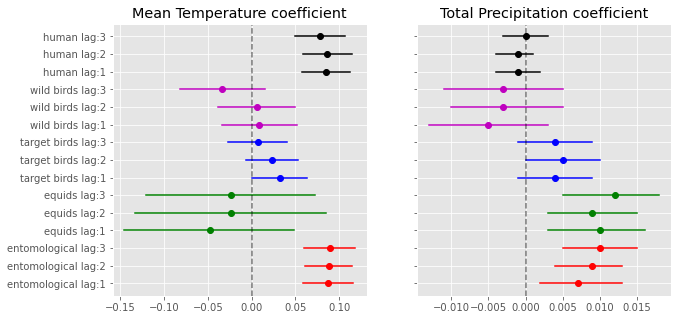

In [53]:
# visualizzazione coefficienti e intervallo di confidenza
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for c, y in enumerate(dfrs.Y.unique()):
        for l in dfrs.lag.unique():
            _dfrs = dfrs[(dfrs.Y==y)&(dfrs.lag==l)]
            y_plot = f"{y} lag:{l}"
            for i, x in enumerate(["temp", "prec"]):
                x_plot = _dfrs[x].values[0]
                ax[i].plot(x_plot, y_plot, "o", color=colors[c])
                x_lo = _dfrs[f"{x} lo"].values[0]
                x_up = _dfrs[f"{x} up"].values[0]
                ax[i].plot([x_lo, x_up], [y_plot, y_plot], color=colors[c])
    ax[0].axvline(0, color="k", ls="--", alpha=.5)
    ax[1].axvline(0, color="k", ls="--", alpha=.5)
    ax[0].set_title("Mean Temperature coefficient")
    ax[1].set_title("Total Precipitation coefficient")

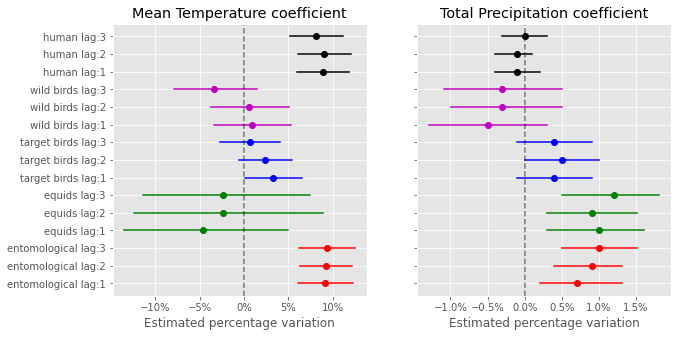

In [58]:
# interpretazione coefficienti come variazione percentuale di y
# per incremento di una unità nella variabile indipendente
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for c, y in enumerate(dfrs.Y.unique()):
        for l in dfrs.lag.unique():
            _dfrs = dfrs[(dfrs.Y==y)&(dfrs.lag==l)]
            y_plot = f"{y} lag:{l}"
            for i, x in enumerate(["temp", "prec"]):
                x_plot = np.exp(_dfrs[x].values[0]) - 1
                ax[i].plot(x_plot, y_plot, "o", color=colors[c])
                x_lo = np.exp(_dfrs[f"{x} lo"].values[0]) - 1
                x_up = np.exp(_dfrs[f"{x} up"].values[0]) -1
                ax[i].plot([x_lo, x_up], [y_plot, y_plot], color=colors[c])
    ax[0].axvline(0, color="k", ls="--", alpha=.5)
    ax[1].axvline(0, color="k", ls="--", alpha=.5)
    ax[0].set_title("Mean Temperature coefficient")
    ax[1].set_title("Total Precipitation coefficient")
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1,0))
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1,1))
    ax[0].set_xlabel("Estimated percentage variation")
    ax[1].set_xlabel("Estimated percentage variation")
    fig.savefig("correlation_percent_variation.png", bbox_inches="tight")
    fig.savefig("correlation_percent_variation.pdf", bbox_inches="tight")

In [55]:
iwdf = pd.DataFrame(infl_week)

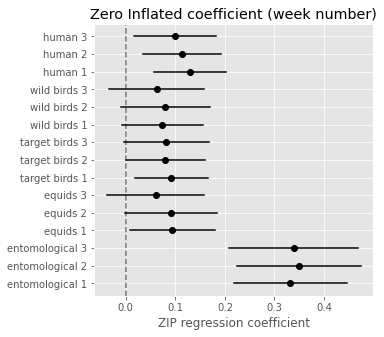

In [56]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(5, 5), sharey=True)
    for i in iwdf.index:
        _iwdf = iwdf.loc[i]
        y_plot = f"{_iwdf.Y} {_iwdf.lag}"
        x_plot = _iwdf.mu
        ax.plot(x_plot, y_plot, "o", color="k")
        x_lo = _iwdf.lo
        x_up = _iwdf.up
        ax.plot([x_lo, x_up], [y_plot, y_plot], color="k")
    ax.axvline(0, color="k", ls="--", alpha=.5)
    ax.set_xlabel("ZIP regression coefficient")
    ax.set_title("Zero Inflated coefficient (week number)")
    plt.savefig("inflate_week_coefficient.png", bbox_inches="tight")
    plt.savefig("inflate_week_coefficient.pdf", bbox_inches="tight")

In [57]:
# modello ZIP

\begin{equation*}
\left\{
\begin{array}{l}
y'_{ri} = \left\{
       \begin{array}{ll}
       0 & \iff y_{ri} = 0
       \\
       1 & \textrm{otherwise}
       \end{array}
       \right.
\\
\displaystyle \Pr(y'_{ri} = 0) = \mathrm{logit}^{-1}(\alpha_0 + \alpha_1 X_{0ri}) = \phi_{ri}
\\
\Pr(y_{ri}=0) = \phi_{ri} + (1-\phi_{ri})e^{-\lambda_{ri}}
\\
\displaystyle \Pr(y_{ri}=k) = (1-\phi_{ri}) \frac{\lambda_{ri}^k e^{-\lambda_{ri}}}{k!}
\\
\displaystyle \ln\lambda_{ri} = \beta_0 + \sum_{j=1}^{2}\sum_{r=0}^{R} \beta_{j} X_{jrl} + \sum_{r=1}^R \left( \beta_{(r)} \delta_{ri} + \beta_{(1r)} \delta_{ri} X_{1rl} \right)
\\
l=i-L
\end{array}
\right.
\end{equation*}

where

- $y_{ri}$ is the dependent variable (new weekly West-Nile cases of human, equids, target birds, wild birds, or mosquito pools) in the $r$-th region and the $i$-th observation

- $y'_{ri}$ is zero if and only if $y_{ri}$ is zero

- $\phi_{ri}$ is the probability that $y'_{ri}$ is zero

- $\lambda_{ri}$ is the mean parameter of $y_{ri}$ Poisson distribution

- $X_{0ri}$ is the week number of the $r$-th region in the $i$-th observation

- $X_{1rl}$ is the mean weekly temperature in °C in the $r$-th region and the $l$-th observation

- $X_{2rl}$ is the total weekly precipitation in mm in the $r$-th region and the $l$-th observation

- $l=1-L$ where $L$ is the weekly lag of the model

- $\delta_{ri}$ is the categorical variable corresponding to the name of the $r$-th region in the $i$-th observation

- $\alpha_0$ and $\alpha_1$ are Intercept and Slope coefficients of the logistic regression model that estimates the probability $\Pr(y'_{ri}=0)$

- $\beta_0$ is the Intercept, $\beta_1$ and $\beta_2$ the Slope coefficient of the Poisson regression model for the mean weekly temperature and the total precipitations, respectively

- $\beta_{(r)}$ is the Slope coefficient of the $r$-th region and $\beta_{(1r)}$ the Interaction coefficient between the mean weekly temperature in $r$-th region and the region name (added because of etherogeneous regional temperature profiles)